## Анализ пользовательского поведения в мобильном приложении

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
 * EventName — название события;
 * DeviceIDHash — уникальный идентификатор пользователя;
 * EventTimestamp — время события;
 * ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248
— экспериментальная.


### План <a id="step0"></a>

#### 1.   [Шаг 1](#step1) Загрузка данных. 
#### 2.  [Шаг 2](#step2)  Предобработка данных. 
#### 3.  [ Шаг 3](#step3) Изучаем и проверяем данные. 
#### 4.  [Шаг 4](#step4) Изучаем воронку событий.
#### 5.  [Шаг 5](#step5) Изучаем результаты эксперимента.
#### 6.  [Шаг 6](#step6) Вывод.

#### Шаг 1. Загрузка данных. <a id="step1"></a>                                                        * [назад к плану](#step0)

In [1]:
import pandas as pd
import re
import scipy.stats as stats
from io import BytesIO 
from scipy import stats as st
import requests
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = -1
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data_review = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
def df_info(df):
    """ вывод базовой информации по датафрейму """
    df.info()
    display(df.describe())
    display(df)

In [5]:
df_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Вывод

Датафрейм без пропусков. Числовые столбцы имеют тип данных int. Столбец EventTimestamp имеет формат unix.

#### Шаг 2. Предобработка данных. <a id="step2"></a>                                                        * [назад к плану](#step0)

Замените названия столбцов на удобные для вас;
Проверьте пропуски и типы данных. Откорректируйте, если нужно;
Добавьте столбец даты и времени, а также отдельный столбец дат;

In [6]:
    # поменяем названия столбцов
data = data.rename(columns={'EventName':'event_type',
                            'DeviceIDHash':'user_id',
                            'EventTimestamp':'event_datetime',
                            'ExpId':'exp_id'})

In [7]:
data.head(5)

,event_type,user_id,event_datetime,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
data['date_time'] = pd.to_datetime(data['event_datetime'], unit='s') # добавляем новый столбец дата и время
data['date'] = data['date_time'].dt.date                            # добавляем новый столбец дата

In [9]:
data.head(5)

,event_type,user_id,event_datetime,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
data.duplicated().sum() # проверяем на дубликаты

413

In [11]:
data = data.drop_duplicates() #  удаляем дубликаты

### Вывод

Произвели замену названий столбцов. Преобразовали столбец с датой и временем из unix в datetime. Удалили 413 дубликатов. Добавили столбцы date и date_time.

#### Шаг 3. Изучаем и проверяем данные. <a id="step3"></a>                                                        * [назад к плану](#step0)

In [12]:
data['event_type'].value_counts().reset_index() # узнаем сколько всего типов событий в логе

,index,event_type
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


In [13]:
data['user_id'].nunique() # узнаем сколько всего уникальных пользователей

7551

In [14]:
(data.groupby(['user_id']).agg({'event_type': 'count'})).mean() # сколько событий приходится на 1 пользователя

event_type    32.275593
dtype: float64

In [15]:
data['date'].min() # самая поздняя дата

datetime.date(2019, 7, 25)

In [16]:
data['date'].max() # самая ранняя дата

datetime.date(2019, 8, 7)

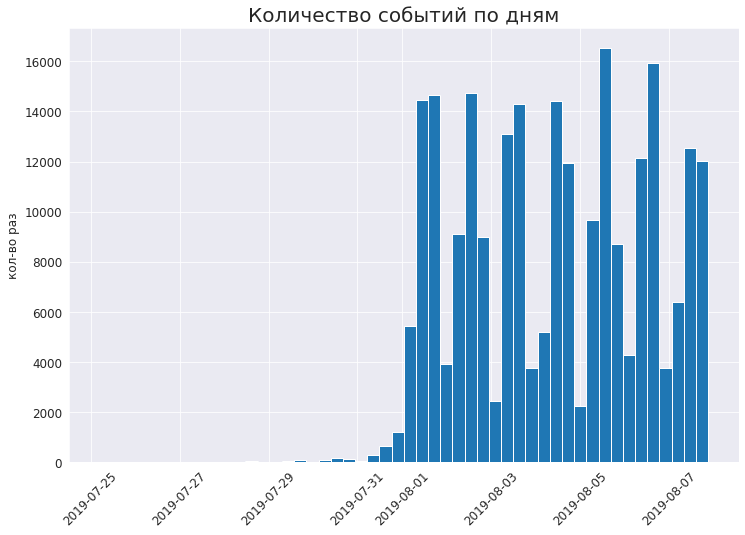

In [17]:
plt.figure(figsize=(12, 8))
data['date_time'].hist(bins=50)
plt.title('Количество событий по дням', fontsize=20)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('кол-во раз',fontsize=12)
plt.show()

In [18]:
later_01_08 = (data[data['date_time'] < "2019-07-31 23:59:59"])['date_time'].count() # узнаем сколько значений ранее 01.08.2019
later_01_08                  

2825

In [19]:
share_later_01_08 = later_01_08 / data['date_time'].count() # узнаем долю значений ранее 01.08.2019
share_later_01_08                                         

0.011591503120473672

In [20]:
(data[data['date_time'] < "2019-07-31 23:59:59"])['user_id'].nunique()

1451

Отброшенные данные ранее 01.08.2019 г. - это 2 825 значений, что составляет 1% от всех значений или 1 451 пользователь.

In [21]:
data_new = (data[data['date_time'] > "2019-07-31 23:59:59"]) # отбрасываем все значения ранее 01.08.2019
data_new['exp_id'].nunique() # узнаем сколько групп в новом фрейме

3

### Вывод

В логе всего 5 типов событий. Всего уникальных пользователей 7551. Все события уложились в период с 25.07.2019 по 07.08.2019. Были отброшены данные ранее 01.08.2019. Отброшенные данные ранее 01.08.2019 г. - это 2 825 значений, что составляет 1% от всех значений или 1 451 пользователь.

#### Шаг 4. Изучаем воронку событий.<a id="step4"></a>                                                        * [назад к плану](#step0)

In [22]:
user_id_total = data_new['user_id'].nunique() # узнаем сколько всего уникальных пользователей
user_id_total

7534

In [23]:
    # таблица всех событий с количеством уникальных пользователей
event_type_users = data_new.groupby(['event_type']).agg({'user_id': 'nunique'}).\
                        sort_values(by='user_id', ascending=False).reset_index()
event_type_users['total_user'] = user_id_total # добавляем столбец с общим количеством уникальных пользователей
event_type_users['ratio_user'] = (event_type_users['user_id'] / event_type_users['total_user']).round(2) # считаем долю
event_type_users

,event_type,user_id,total_user,ratio_user
0,MainScreenAppear,7419,7534,0.98
1,OffersScreenAppear,4593,7534,0.61
2,CartScreenAppear,3734,7534,0.50
3,PaymentScreenSuccessful,3539,7534,0.47
4,Tutorial,840,7534,0.11


Все события происходят в той последовательности, которая показана в таблице. Событие 4(Tutorial) не является обязательным и его можно исключить из воронки событий.

In [24]:
funnel = event_type_users.drop(['total_user','ratio_user'], axis='columns', inplace=True)

In [25]:
funnel = event_type_users.drop([4]) # удаляем необязательное действие Tutorial

In [26]:
funnel

,event_type,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [27]:
funnel['ratio'] = funnel['user_id'].pct_change()
funnel

,event_type,user_id,ratio
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,-0.380914
2,CartScreenAppear,3734,-0.187024
3,PaymentScreenSuccessful,3539,-0.052223


38% теряются после 1 этапа - просмотра главного экрана

Сделаем воронку с учетом последовательности событий

In [28]:
users = data_new.pivot_table(  # Для пользователей посчитаем время первого срабатывания каждого события
        index='user_id', 
        columns='event_type', 
        values='date_time',
        aggfunc='min').reset_index()
users.drop(['Tutorial'], axis='columns', inplace=True)
users.head(5)

event_type,user_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
1,6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
2,6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
3,7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
4,7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [29]:
    # задаем последовательность событий согласно нашей воронки
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen_appear = users[step_1].shape[0]
n_offers_screen_appear = users[step_2].shape[0]
n_cart_screen_appear = users[step_3].shape[0]
n_payment_screen_successful = users[step_4].shape[0]

print('Посетителей:', n_main_screen_appear)
print('Посмотрели экран предложения', n_offers_screen_appear)
print('Добавили товар в корзину:', n_cart_screen_appear)
print('Оплатили:', n_payment_screen_successful)

Посетителей: 7419
Посмотрели экран предложения 4201
Добавили товар в корзину: 1767
Оплатили: 454


Узнаем сколько пользователей из первого события (просмотр основного экрана) дошли до последнего события(оплата)

In [30]:
user_step_4 = users[step_1 & (users['PaymentScreenSuccessful'] > users['MainScreenAppear'])].shape[0]
print('Оплатили:', user_step_4, 'пользователя оплачивают - это составляет ', '{:.0%}'.\
      format(user_step_4/n_main_screen_appear),'от пользователей из первого события')

Оплатили: 3268 пользователя оплачивают - это составляет  44% от пользователей из первого события


### Вывод

Событие 4(Tutorial) не является обязательным и его можно исключить из воронки событий.
38% теряются после 1 этапа - просмотра главного экрана. До оплаты дошли 3268 пользователя  - это составляет  44% от пользователей из первого события (просмотр главного экрана).

#### Шаг 5. Изучаем результаты эксперимента. <a id="step5"></a>                                                        * [назад к плану](#step0)

Найдем количество пользователей в каждой экспериментальной группе.

In [31]:
n_user_group = data_new.groupby(['exp_id']).agg({'user_id': 'nunique'}).reset_index()
n_user_group

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


In [32]:
    # выведем переменные по количеству пользователей оплативших по каждой группе 
n_users_pay_246 = data_new.query('exp_id==246 and event_type=="PaymentScreenSuccessful"')['user_id'].nunique()
n_users_pay_247 = data_new.query('exp_id==247 and event_type=="PaymentScreenSuccessful"')['user_id'].nunique()
n_users_pay_248 = data_new.query('exp_id==248 and event_type=="PaymentScreenSuccessful"')['user_id'].nunique()
display(n_users_pay_246, n_users_pay_247, n_users_pay_248)

1200

1158

1181

In [33]:
    # выведем переменные по количеству пользователей по каждой группе 
n_users_246 = data_new.query('exp_id==246')['user_id'].nunique()
n_users_247 = data_new.query('exp_id==247')['user_id'].nunique()
n_users_248 = data_new.query('exp_id==248')['user_id'].nunique()
display(n_users_246, n_users_247, n_users_248)

2484

2513

2537

А/А тест. Проверяем гипотезу о равенстве долей конверсий между 246 и 247 группами. Н0 - доли между группами равны. 
Н1 - между долями есть значимая разница.

In [34]:
alpha = .05 # критический уровень статистической значимости

payments = np.array([n_users_pay_246, n_users_pay_247])
views = np.array([n_users_246, n_users_247])
p1 = payments[0]/views[0]
p2 = payments[1]/views[1]
p_combined = (payments[0] + payments[1]) / (views[0] + views[1])
difference = p1 - p2 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/views[0] + 1/views[1]))
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нет статистически значимой разницы между выборками групп 246 и 247

In [35]:
    # найдем количество уникальных пользователей по каждому событию для каждой группы
event_type_by_group=data_new.pivot_table(index = 'event_type', values= 'user_id', columns = 'exp_id', aggfunc = 'nunique')
event_type_by_group = event_type_by_group.sort_values(by = 246, ascending = False)
event_type_by_group[249] = event_type_by_group[246] + event_type_by_group[247]
event_type_by_group

exp_id,246,247,248,249
event_type,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


Самое популярное событие MainScreenAppear

In [36]:
group_exp = data_new.groupby('exp_id')['user_id'].agg({'nunique', 'count'}).reset_index()
group_exp.loc[3] = [249, group_exp.loc[0, 'count']+group_exp.loc[1, 'count'], group_exp.loc[0, 'nunique']+group_exp.loc[1, 'nunique']]
group_exp

,exp_id,nunique,count
0,246,2484,79302
1,247,2513,77022
2,248,2537,84563
3,249,156324,4997


In [37]:
#print('Oткрыли главную страницу', event_type_by_group.loc['MainScreenAppear', 246], 'посетителей из 246 группы')
print('{:.1%}'.format(event_type_by_group.loc['MainScreenAppear', 246] / group_exp.loc[0,'nunique']),\
      'пользователей группы 246 посетили главную страницу')

98.6% пользователей группы 246 посетили главную страницу


In [38]:
#print('Oткрыли главную страницу', event_type_by_group.loc['MainScreenAppear', 247], 'посетителей из 247 группы')
print('{:.1%}'.format(event_type_by_group.loc['MainScreenAppear', 247] / group_exp.loc[0,'nunique']),\
      'пользователей группы 247 посетили главную страницу')

99.7% пользователей группы 247 посетили главную страницу


In [39]:
#print('Oткрыли главную страницу', event_type_by_group.loc['MainScreenAppear', 248], 'посетителей из 248 группы')
print('{:.1%}'.format(event_type_by_group.loc['MainScreenAppear', 248] / group_exp.loc[0,'nunique']),\
      'пользователей группы 248 посетили главную страницу')

100.4% пользователей группы 248 посетили главную страницу


Доля пользователей, совершивших событие MainScreenAppear во всех 3-х группах равно 99%.

А/А-тест. Сравниваем 2 контрольные группы 246 и 247. Н0 - статистически значимой разницы между долями 2-х групп нет. Н1 - между долями 2-х групп есть статистически значимая разница.

In [40]:
def stat (group_1, group_2):
    
    """ проверка статистической значимости различий между группами """
    
    for_auto = [
        'MainScreenAppear',
        'OffersScreenAppear',
        'CartScreenAppear',
        'PaymentScreenSuccessful',
        'Tutorial']
    for i in for_auto:
        events_1 = event_type_by_group.loc[i, group_1]
        events_2 = event_type_by_group.loc[i, group_2]
        leads_1 = group_exp[group_exp['exp_id'] == group_1]['nunique'].values[0]
        leads_2 = group_exp[group_exp['exp_id'] == group_2]['nunique'].values[0]
        alpha = .05 
        bonferroni_alpha = alpha / 5 # 5 событий * 1 группа
        purchases = np.array([events_1, events_2])
        leads = np.array([leads_1, leads_2]) 
        p1 = purchases[0]/leads[0]       
        p2 = purchases[1]/leads[1]        
        p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])       
        difference = p1 - p2        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))        
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print()
        print('Событие:',i,',' , group_1, 'v', group_2)
        print('p-значение: ', p_value)
  
        if (p_value < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

stat (246, 247)


Событие: MainScreenAppear , 246 v 247
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear , 246 v 247
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear , 246 v 247
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful , 246 v 247
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial , 246 v 247
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между долями 2-х контрольных групп 246 и 247 нет.

А/В-тест. Сравниваем 3 группы: экспериментальную 248 группу с контрольными 246,247 и объединенной контрольной группой 249.  
Н0 - статистически значимой разницы между долями 2-х групп нет. Н1 - между долями 2-х групп есть статистически значимая разница. 

In [41]:
def stat1 (group_1, group_2):
    
    """ проверка статистической значимости различий между группами """
    
    for_auto = [
        'MainScreenAppear',
        'OffersScreenAppear',
        'CartScreenAppear',
        'PaymentScreenSuccessful',
        'Tutorial']
    for i in for_auto:
        events_1 = event_type_by_group.loc[i, group_1]
        events_2 = event_type_by_group.loc[i, group_2]
        leads_1 = group_exp[group_exp['exp_id'] == group_1]['nunique'].values[0]
        leads_2 = group_exp[group_exp['exp_id'] == group_2]['nunique'].values[0]
        alpha = .05 
        bonferroni_alpha = alpha / 15 # 5 событий * 3 группы
        purchases = np.array([events_1, events_2])
        leads = np.array([leads_1, leads_2]) 
        p1 = purchases[0]/leads[0]       
        p2 = purchases[1]/leads[1]        
        p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])       
        difference = p1 - p2        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))        
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print()
        print('Событие:',i,',' , group_1, 'v', group_2)
        print('p-значение: ', p_value)
  
        if (p_value < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

for g1, g2 in ((248, 247), (248, 246), (249,248)):
        stat1 (g1, g2) 
        bonferroni_alpha = alpha / 15


Событие: MainScreenAppear , 248 v 247
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear , 248 v 247
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear , 248 v 247
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful , 248 v 247
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial , 248 v 247
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear , 248 v 246
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear , 248 v 246
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую

Статистически значимой разницы между долями экспериментальной 248 и 3-х контрольных групп 246,247 и объединенной 249 нет. Изменение шрифта не повлияло на восприятие посетителей.

### Вывод

Нет статистически значимой разницы между выборками групп 246 и 247. Самое популярное событие MainScreenAppear. Доля пользователей, совершивших событие MainScreenAppear во всех 3-х группах равно 99%. Нет статистически значимой разницы между выборками групп 246,247 и 248. Уровень значимости А/А-тест 0,01 = 0,05/5 гипотез. Уровень значимости А/В-тест 0,0033 = 0,05 / 15 гипотез.

#### Шаг 6. Вывод. <a id="step6"></a>                                                        * [назад к плану](#step0)

Датафрейм без пропусков. Числовые столбцы имеют тип данных int. Столбец EventTimestamp имеет формат unix.
Произвели замену названий столбцов. Преобразовали столбец с датой и временем из unix в datetime. Удалили 413 дубликатов. Добавили столбцы date и date_time.
В логе всего 5 типов событий. Всего уникальных пользователей 7551. Все события уложились в период с 25.07.2019 по 07.08.2019. Были отброшены данные ранее 01.08.2019. Отброшенные данные ранее 01.08.2019 г. - это 2 825 значений, что составляет 1% от всех значений или 1 451 пользователь.
Событие 4(Tutorial) не является обязательным и его можно исключить из воронки событий. 38% теряются после 1 этапа - просмотра главного экрана. До оплаты дошли 3268 пользователя - это составляет 44% от пользователей из первого события (просмотр главного экрана).
Нет статистически значимой разницы между выборками групп 246 и 247. Самое популярное событие MainScreenAppear. Доля пользователей, совершивших событие MainScreenAppear во всех 3-х группах равно 99%. Нет статистически значимой разницы между выборками групп 246,247 и 248 по событию MainScreenAppear. Уровень значимости А/А-тест 0,01 = 0,05/5 гипотез. Уровень значимости А/В-тест 0,0033 = 0,05 / 15 гипотез.
#### Резюме. Изменение шрифта никак не повлияло на восприятие пользователей, а следовательно и продажи.
